In [1]:
from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristicCopy1 import NumericHeuristic5
from pct.tree.splitter.splitterCopy1 import Splitter
from pct.tree.treeCopy2 import Tree

In [2]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df


In [3]:
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv("C:/Users/13447/Desktop/Stats thesis/ml-1m/ml-1m/ratings.dat",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
data

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [11]:
data = threshold_interactions_df(data,'user_id','item_id',100,100)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

# split to train, X and eval sets
al,train,_ = train_test_split(matrix,1)

# ml 1M
X_matrix,test,_ = train_test_split(al,30)

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [12]:
train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
train_copy = (train.tolil()).copy()
x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
x_df= x_df.sort_index(axis=1).sort_index(axis=0) 
x_df

,1,2,3,4,5,6,7,10,11,12,...,3918,3926,3927,3928,3930,3932,3937,3948,3949,3952
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()
    
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [39]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()
    
    for count in range(0,iteration-1):
        scores = strategy(train_copy)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [17]:
def elicitation_p(train, test, X, tree_model, iteration, k, idx_to_rid, idx_to_cid):
    rmse, mae = [], []

    # Initial evaluation of the SVD recommender
    train_df = matrix_to_df_2(train, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)

    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions = algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))

    # Initialization
    c_u_dict = {}
    all_items = list(range(0, train.shape[1]))
    X_matrix = (X.tolil()).copy()
    train_copy = (train.tolil()).copy()

    for count in range(iteration - 1):
        # Step 1: Convert to DataFrame and train the tree
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)

        # Step 2: Use the tree to predict ratings for unrated items
        pred_df = tree_model.predict_test(x_df)  # Same structure as x_df, values are predicted scores

        for u in range(train.shape[0]):
            if count == 0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items, p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()

            # Rank the predictions and select top-k
            pred_u = pred_df.iloc[u].to_dict()
            pred_dict = {i: pred_u[idx_to_cid[i]] for i in c_u}
            ranking_u = sorted(pred_dict.items(), key=lambda x: -x[1])
            topk_u = [item for item, _ in ranking_u[:k]]
            c_u_dict[u] = set_diff(c_u, topk_u)

            # Add items that the user has actually rated into train_copy
            px_u = X_matrix.getrow(u).nonzero()[1]
            recom = [item for item in topk_u if item in px_u]
            for item in recom:
                train_copy[u, item] = X[u, item]
                X_matrix[u, item] = 0

        # Step 3: Retrain SVD and record RMSE
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)

        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions = algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

        print(f"Iteration {count+1} done.")

    return rmse, mae


In [41]:
entropy = elicitation_np(train,test,X_matrix,i_entropy_0,iteration=10,k=20,positive=True)

RMSE: 1.1625
MAE:  0.9679
RMSE: 1.0756
MAE:  0.8347
1
RMSE: 1.0693
MAE:  0.8302
2
RMSE: 1.0607
MAE:  0.8255
3
RMSE: 1.0591
MAE:  0.8229
4
RMSE: 1.0540
MAE:  0.8191
5
RMSE: 1.0505
MAE:  0.8161
6
RMSE: 1.0494
MAE:  0.8140
7
RMSE: 1.0411
MAE:  0.8092
8
RMSE: 1.0357
MAE:  0.8051
9


In [42]:
rand = elicitation_np(train,test,X_matrix,i_random,iteration=10,k=20,positive=True)

RMSE: 1.1615
MAE:  0.9672
RMSE: 1.1450
MAE:  0.8776
1
RMSE: 1.1296
MAE:  0.8670
2
RMSE: 1.1150
MAE:  0.8557
3
RMSE: 1.1032
MAE:  0.8473
4
RMSE: 1.0944
MAE:  0.8396
5
RMSE: 1.0870
MAE:  0.8347
6
RMSE: 1.0753
MAE:  0.8259
7
RMSE: 1.0687
MAE:  0.8211
8
RMSE: 1.0636
MAE:  0.8166
9


In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tree = Tree(max_depth=7)
pct = elicitation_p(train, test, X_matrix, tree, iteration=10, k=20,
                          idx_to_rid=idx_to_rid, idx_to_cid=idx_to_cid)

RMSE: 1.1616
MAE:  0.9670
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0711
MAE:  0.8363
Iteration 1 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0676
MAE:  0.8308
Iteration 2 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0638
MAE:  0.8267
Iteration 3 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0585
MAE:  0.8228
Iteration 4 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0487
MAE:  0.8157
Iteration 5 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0423
MAE:  0.8119
Iteration 6 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0366
MAE:  0.8078
Iteration 7 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0337
MAE:  0.8056
Iteration 8 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0287
MAE:  0.8010
Iteration 9 done.


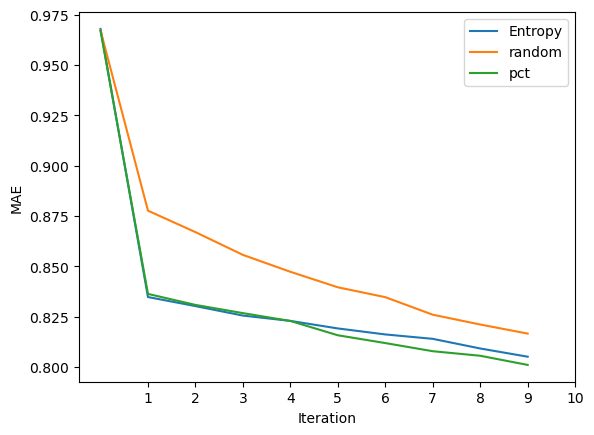

In [45]:
x = np.arange(10) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy[1], label='Entropy')
ax1.plot(x, rand[1], label='random')
ax1.plot(x, pct[1], label='pct')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.xticks(range(1, 11)) 
plt.show()

# plt.xticks(x, list_i)

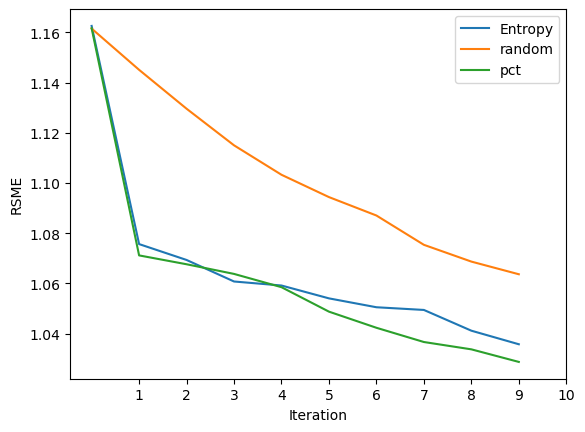

In [47]:
x = np.arange(10) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy[0], label='Entropy')
ax1.plot(x, rand[0], label='random')
ax1.plot(x, pct[0], label='pct')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RSME")
plt.xticks(range(1, 11)) 
plt.show()

# plt.xticks(x, list_i)